# Сегментация

In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# plt.style.use('ggplot')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization, Dense
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Nadam
from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from PIL import Image
from tensorflow.keras.utils import plot_model
import os
from keras import backend as keras

*******************

In [3]:
# метрики и потери
def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [4]:
PAHT_image = './_images/'
PAHT_mask = './_segm/'

In [5]:
# список файлов
imag = os.listdir(PAHT_image)
imag_mask = os.listdir(PAHT_mask)
images = []
segments = []
image_size = (128, 128)

In [6]:
for i_name in imag:
    if i_name[-3:] == 'jpg':
        images.append(image.load_img(PAHT_image+i_name, target_size=image_size))

In [7]:
for m_name in imag_mask:
    if m_name[-3:] == 'png':
        segments.append(image.load_img(PAHT_mask+m_name, target_size=image_size))

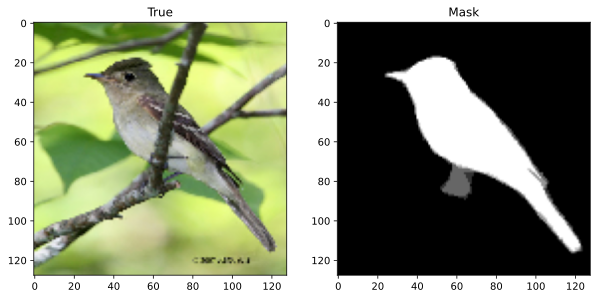

In [33]:
# изображение и маска
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.imshow(images[13].convert('RGBA'))
plt.title('True')
plt.subplot(1,2,2)
plt.imshow(segments[13].convert('RGBA'))
plt.title('Mask')
plt.show()

In [9]:
imag_arr = []
for img in images:
    x = image.img_to_array(img)
    imag_arr.append(x)
imag_arr = np.array(imag_arr)/255

In [10]:
mask_arr = []
for mask in segments:
    x = image.img_to_array(mask)
    mask_arr.append(x)
mask_arr = np.array(mask_arr)/255

In [11]:
# делим на тест и трейн
N = 10000
mask_train = np.random.choice(11788, N, replace=False)
mask_test = list(set(np.arange(11788)) - set(mask_train))
mask_test = np.array(mask_test)
yTrain = mask_arr[mask_train,:,:,:]
xTrain = imag_arr[mask_train,:,:,:]

In [12]:
yTest = mask_arr[mask_test,:,:,:]
xTest = imag_arr[mask_test,:,:,:]

*********************************
# модель U-NET

In [13]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    x = inputs

    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2, padding='same')

    x = last(x)
    layerC1 = Conv2D(128, (3, 3), padding='same')
    x = layerC1(x)
    layerC2 = Conv2D(256, (2, 2), padding='same')
    x = layerC2(x)
    layerC0 = Conv2D(3, (2, 2), activation='sigmoid', padding='same')
    x = layerC0(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [14]:
OUTPUT_CHANNELS = 3

In [15]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [16]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [17]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer=Nadam(learning_rate=0.0001), loss=[dice_coef_loss], metrics=[dice_coef])

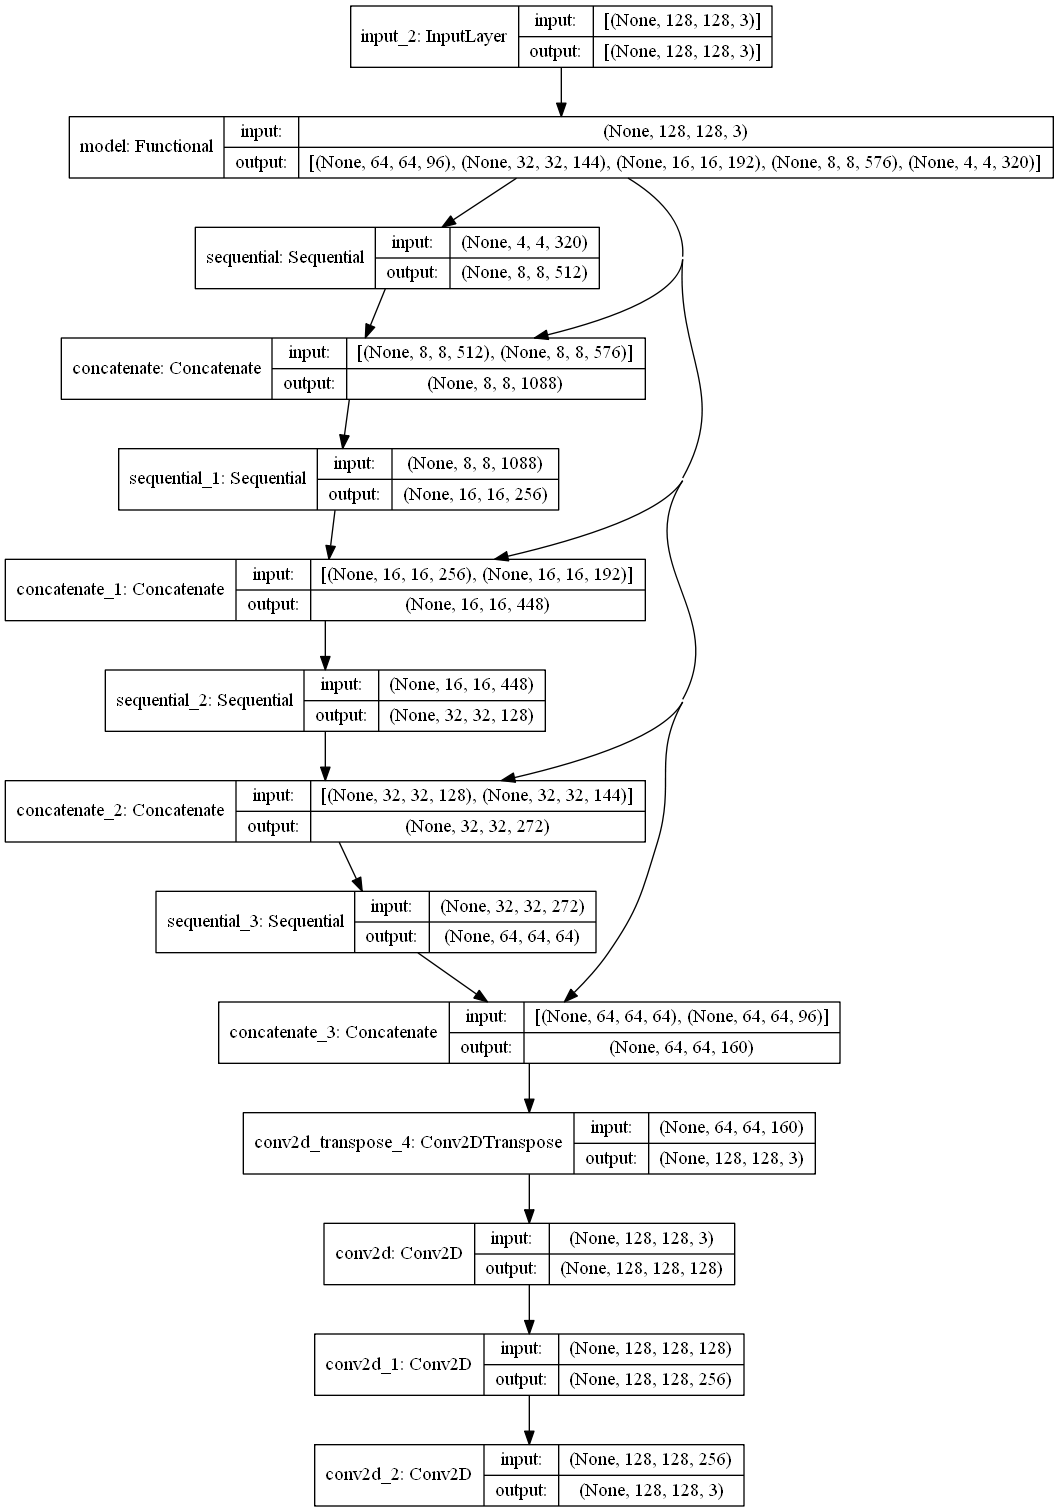

In [18]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [19]:
history = model.fit(xTrain, yTrain, epochs=5, batch_size=25, verbose=0)

In [20]:
predictions = model.predict(xTest)

In [23]:
score = model.evaluate(xTest, yTest)

56/56 [==============================] - 13s 236ms/step - loss: -0.8758 - dice_coef: 0.8758


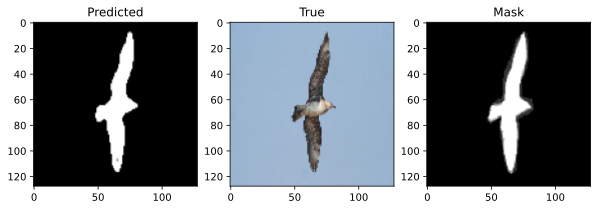

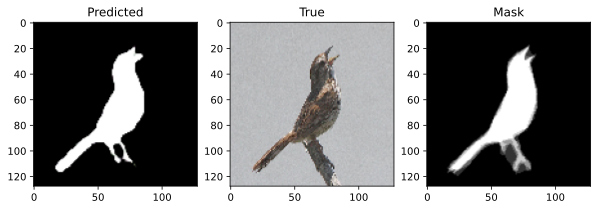

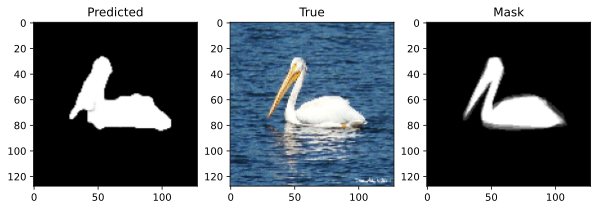

In [32]:
for n in [1, 151, 913]:
    plt.figure(figsize=(10, 5))
    plt.subplot(1,3,1)
    plt.imshow(predictions[n])
    plt.title('Predicted')
    plt.subplot(1,3,2)
    plt.imshow(xTest[n])
    plt.title('True')
    plt.subplot(1,3,3)
    plt.imshow(yTest[n])
    plt.title('Mask')
    plt.show()